In [29]:
# GENERATE FILE FOR probeTm.py WITH TWO COLUMNS: SEQUENCE NUBMER AND PROBE SEQUENCE #
read_filename = 'chr6_only/rosa26_probes_sC.bed'
write_filename = 'chr6_only/rosa26_probes_TM.txt'

# read file output from structureCheck.py #
with open(read_filename) as file:
    probes = [(k+1, line.split('	')[3]) for k, line in enumerate(file)]

# write to new file for input to probeTm.py #
with open(write_filename, 'w') as file:
    for probe in probes:
        file.write(f'{probe[0]}\t{probe[1]}\n')

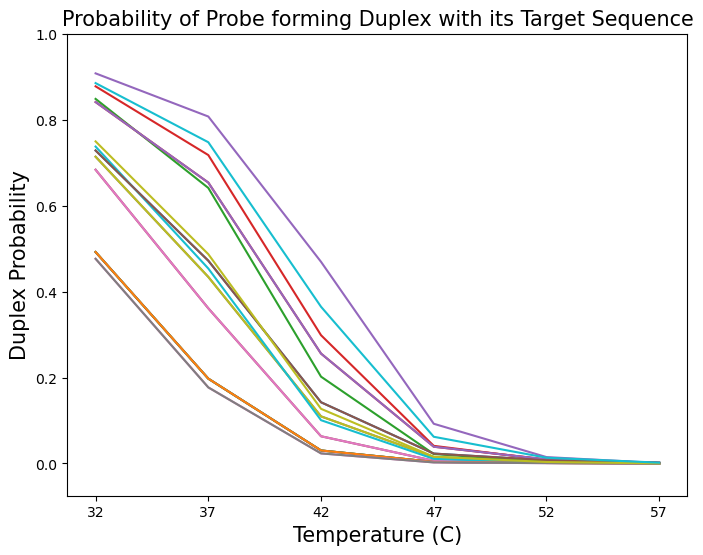

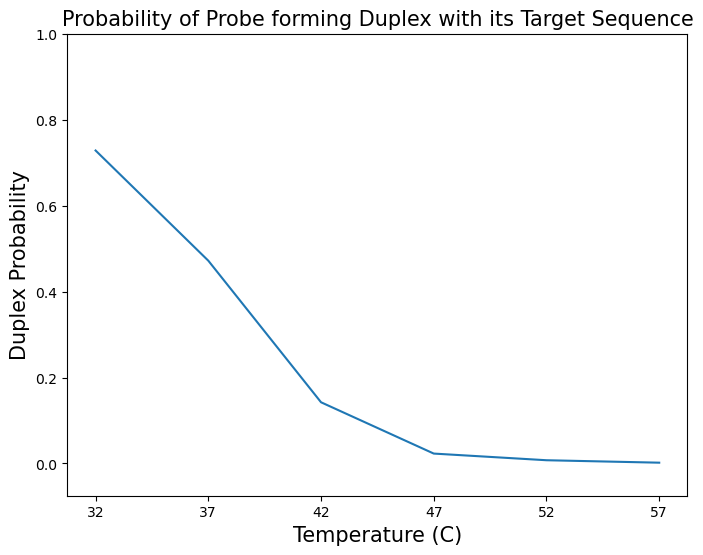

In [92]:
# GENERATE DUPLEX PROBABILITIES AT 6 TEMPS FOR A GIVEN SEQUENCE
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from Bio.SeqUtils import MeltingTemp, GC

##########################################################################################

def calc_TM(seq, Na, fmd):
    '''Calculates melting temperature of probe sequence given Na and formamide conc.'''
    tm = round(MeltingTemp.Tm_NN(seq, Na=Na), 2)
    tm_fmd = round(MeltingTemp.chem_correction(float(tm), fmd=fmd), 2)
    return tm_fmd

##########################################################################################

def calc_duplex_prob(sam_filename, final_probeset_filename, temp):
    '''Calculates probability of given probe forming a duplex with its target sequence for each probe at given temp.'''
    # read in final probeset BED file #
    with open(final_probeset_filename) as file:
        final_probeset = [line.split('\t')[3] for line in file]

    # read in SAM file #
    with open(sam_filename) as file:
        sam = [line for line in file]

    # set up LDA model to predict duplex probability based on probe length, GC content, and alignment score to target seq #
    # Values from models published in Beliveau, et al. (2018) paper. #
    temps = np.array([32, 37, 42, 47, 52, 57])
    if temp not in temps:
        print(f'hey asshole, temp has to be one of {temps}')
        return None
    coefs = np.array([[-0.14494789, 0.18791679, 0.02588474],
                    [-0.13364364, 0.22510179, 0.05494031],
                    [-0.09006122, 0.25660706, 0.1078303],
                    [-0.01593182, 0.24498485, 0.15753649],
                    [0.01860365, 0.1750174, 0.17003374],
                    [0.03236755, 0.11624593, 0.24306498]])
    intercepts = np.array([-1.17545204, -5.40436344, -12.45549846,
                        -19.32670233, -20.11992898, -23.98652919])
    classes = np.array([-1, 1])

    # initialize LDA model with temp-specific parameters #
    index = np.where(temps==temp)
    clf = LinearDiscriminantAnalysis()
    clf.coef_ = coefs[index]
    clf.intercept_ = intercepts[index]
    clf.classes_ = classes

    # collate inputs for LDA model as [probe length, alignment score, GC content] #
    clf_inputs = []
    for k in range(len(sam)):
        probe_seq = sam[k].split('\t')[9]
        align_score = sam[k].split('\t')[12].split(':')[2]
        GC_content = GC(probe_seq)

        if probe_seq in final_probeset:
            clf_inputs.append([len(probe_seq), int(align_score), GC_content])

    # predict probabilities (results are [prob_no_dup, prob_dup]) #
    probs = (clf.predict_proba(clf_inputs))

    return probs[:, 1]

##########################################################################################

filtering = True
sam_file = 'mouse_chr6/rosa26.sam'
final_probe_file = 'mouse_chr6/rosa26_probes_sC.bed'

##########################################################################################

# collate probabilities #
temps = [32, 37, 42, 47, 52, 57]
all_probs = [calc_duplex_prob(sam_file, final_probe_file, temp)
             for temp in temps]
all_probs = np.swapaxes(all_probs, 0, 1)

# filter out probes which do not form duplexes at low temps #
if filtering:
    all_probs = np.array([probs for probs in all_probs if probs[0] > 0.2])

# all probes #
plt.figure(figsize=(8, 6))
for k in range(len(all_probs)):
    plt.plot(temps, all_probs[k])
plt.xticks(temps)
plt.ylim([-0.075, 1])
plt.xlabel('Temperature (C)', size=15)
plt.ylabel('Duplex Probability', size=15)
plt.title('Probability of Probe forming Duplex with its Target Sequence', size=15)
plt.show()

# single probe
probe_num = 0
plt.figure(figsize=(8, 6))
plt.plot(temps, all_probs[probe_num])
plt.xticks(temps)
plt.ylim([-0.075, 1])
plt.xlabel('Temperature (C)', size=15)
plt.ylabel('Duplex Probability', size=15)
plt.title('Probability of Probe forming Duplex with its Target Sequence', size=15)
plt.show()